In [1]:
""" Faraz Hossein-Babaei   starting 2016/9/5   Eexperiment 1 with python and pandas cont'd.:
Correlating economic and Olympic performances of nations """
""" Data Reading Segment: Reads dataframe from table we created in medals_gdp_1 """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipy_table
from IPython.display import display
plt.style.use('ggplot')
%matplotlib inline

c_medals_df = pd.read_csv("complete_countries_medals_reattributed.csv", index_col=0)
print ("Table 2: Numbers of different medals for different nations at different Summer Olympics, " + \
       "a small portion of the data frame.")
display (c_medals_df.iloc[125:130,:])


Table 2: Numbers of different medals for different nations at different Summer Olympics, a small portion of the data frame.


,1896 G,1896 S,1896 B,1900 G,1900 S,1900 B,1904 G,1904 S,1904 B,1908 G,...,2004 B,2008 G,2008 S,2008 B,2012 G,2012 S,2012 B,2016 G,2016 S,2016 B
UAE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
UGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
UKR,0,0,0,0,0,0,0,0,0,0,...,9,7,5,15,6,5,9,2,5,4
URU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
USA,11,7,2,19,14,14,81,82,78,23,...,27,37,39,36,46,29,29,46,37,38


In [2]:
""" Score calculation Segment """

MDL_KS = [4,2,1]   # relative (g,s,b) medal value coefficients in calculating the score
GLOB_YR_RANGE_TPL = (1960,2016)
NUM_SELECTED_COUNTRIES = 10   # Number of high-ranking countries to select for graph

year_idx_grp_list = range(0, len(c_medals_df.columns), 3)   # col idx of gold medl represents its year
olymp_yrs = [int(j[:4]) for j in c_medals_df.columns[year_idx_grp_list]]
#print (*olymp_yrs, sep='\t')


def yr_idx (yr):
    return c_medals_df.columns.tolist().index(str(yr)+" G")

def ctr_year_score (noc, yr, mdl_coeffs):   # e.g. func("AUS", 2016, [4,2,1]) for rel. score value
    return ctr_idx_score(noc, yr_idx(yr), mdl_coeffs)

def ctr_idx_score (noc, idx, mdl_coeffs):
    mdl_nums = [c_medals_df.loc[noc, c_medals_df.columns[idx+idxR]] for idxR in range(3)]
    return np.dot(mdl_nums, mdl_coeffs)

def ctr_cumul_score (yr_range, noc, mdl_coeffs):
    yr_idx1 = year_idx_grp_list.index(yr_idx(yr_range[0]))
    yr_idx2 = year_idx_grp_list.index(yr_idx(yr_range[1]))
    return sum([ctr_idx_score(noc, idx, mdl_coeffs) for idx in year_idx_grp_list[yr_idx1 : yr_idx2+1]])

def globe_year_score (yr, mdl_coeffs):
    return globe_idx_score(yr_idx(yr), mdl_coeffs)

def globe_idx_score (idx, mdl_coeffs):
    return sum([ctr_idx_score(noc, idx, mdl_coeffs) for noc in c_medals_df.index])

def globe_cumul_score (yr_range, mdl_coeffs):
    yr_idx1 = year_idx_grp_list.index(yr_idx(yr_range[0]))
    yr_idx2 = year_idx_grp_list.index(yr_idx(yr_range[1]))
    return sum([globe_idx_score(idx, mdl_coeffs) for idx in year_idx_grp_list[yr_idx1 : yr_idx2+1]])

def score_share (ctr, idx, mdl_coeffs):
    return ctr_idx_score (noc, idx, mdl_coeffs) / globe_idx_score (idx, mdl_coeffs)


global_score = globe_cumul_score(GLOB_YR_RANGE_TPL, MDL_KS)
yr_idxs = [year_idx_grp_list.index(yr_idx(GLOB_YR_RANGE_TPL[i])) for i in (0,1)]

# all_ctrs_scores_df
all_ctrs_df = pd.DataFrame(data=[[ctr_idx_score(noc, i, MDL_KS) for i in year_idx_grp_list] for \
                                    noc in c_medals_df.index], index=c_medals_df.index)
annual_global_scores = all_ctrs_df.iloc[:].sum()
# all_shares_df
all_shares_df = pd.DataFrame([all_ctrs_df.iloc[:,i] / annual_global_scores[i] for \
                                    i in range(len(year_idx_grp_list))]).T


all_ctrs_forfile_df = all_ctrs_df.copy()
all_shares_forfile_df = all_shares_df.copy()
all_ctrs_forfile_df.columns = olymp_yrs
all_shares_forfile_df.columns = olymp_yrs
all_ctrs_forfile_df.to_csv("all_ctrs_df.csv")
all_shares_forfile_df.to_csv("all_shares_df.csv")


# determining top 10 countries during some period
ctr_hist_score_ser = pd.Series(all_ctrs_df.loc[:, yr_idxs[0]:yr_idxs[1]].sum(axis=1))
select_ctrs = ctr_hist_score_ser.nlargest(NUM_SELECTED_COUNTRIES)
#select_ctrs["IRI"] = ctr_hist_score_ser["IRI"]

# select_ctrs_df
select_ctrs_df = pd.DataFrame([all_ctrs_df.loc[i,:] for i in select_ctrs.index])
# select_ctrs_share_df
select_shares_df = pd.DataFrame([all_shares_df.loc[i,:] for i in select_ctrs.index])

# select_2016normal_df
absolute_col2016_ser = select_ctrs_df.loc[:, year_idx_grp_list.index(yr_idx(2016))]
select_2016normal_df = select_ctrs_df.div(absolute_col2016_ser, axis=0)   # dividing cols by 2016's
# select_shares_2016normal_df
shares_col2016_ser = select_shares_df.loc[:, year_idx_grp_list.index(yr_idx(2016))]
select_shares_2016normal_df = select_shares_df.div(shares_col2016_ser, axis=0)   # dividing by 2016 col

# Redefine the x-axis data from [0,27] to [1896,2016]
select_ctrs_df.columns = olymp_yrs
select_shares_df.columns = olymp_yrs
select_2016normal_df.columns = olymp_yrs
select_shares_2016normal_df.columns = olymp_yrs

year_rng_str = str(GLOB_YR_RANGE_TPL[0]) + "-" + str(GLOB_YR_RANGE_TPL[1])
print ("Table 3: Scores of top 10 nations accumulated over Summer Olympics (" + year_rng_str + ":")
display (pd.DataFrame(select_ctrs, columns=["Score"]))


Table 3: Scores of top 10 nations accumulated over Summer Olympics (1960-2016:


,Score
USA,3715
RUS,3457
GER,2493
CHN,1380
GBR,982
AUS,898
ITA,866
JPN,836
FRA,797
HUN,734


In [3]:
""" Plot Preparation Function Segment: A helper function for drawing graphs to make code shorter """

def prepare_plot (knd, fig_idx, df, ttl, x_lbl, y_lbl, x_tick_lbls, lgd_lbls, clr_map, \
                  ln_styl, ln_wd, mrk, mrk_sz, atten, txt_bool, x_x, idxs, ylog_bool):
    """ Plots DataFrame. Each row is forms a curve in cartesian coords w/ x-axis values of .columns. """
    
    # grp: list of DataFrames anyway, either of single multicol df or list of many sigle-col dfs
    if type(df) == pd.DataFrame:
        grp = [df,]
        df_bool = True
    else:   # then presumably it's a list
        grp = df
        df_bool = False
    
    font = {'font.family':'Arial', 'font.weight':'normal', 'font.size':22}
    
    color_map = clr_map   # matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
    clrs_dict = {}   # other color maps: brg, spectral, Accent, Paired, gnuplot, bone, hsv, jet
    num_plots = len(idxs)
    cnt = 0
    for idx in idxs:   # Building dict of colors for all unique indices of the df(s)
        cur_num = 1.5*cnt / float(num_plots)
        if cur_num > 1: cur_num -= 1
        clrs_dict[idx] = color_map( cur_num )
        cnt += 1
    
    plt.style.use('ggplot')
    plt.figure(fig_idx, figsize=(20,10))   #other options:, dpi=80, facecolor='w', edgecolor='g')
    plt.rcParams.update(font)
    
    x_ticks_vals = []
    for i,itm in enumerate(grp):
        x_ticks_vals += itm.columns.tolist()
        for j,idx in enumerate(itm.index):
            if ylog_bool:
                plt.semilogy( itm.loc[idx,:], color=clrs_dict[idx], linewidth=ln_wd, linestyle=ln_styl, marker=mrk, \
                          markerfacecolor=clrs_dict[idx], markersize=mrk_sz, alpha=atten)
            else:
                plt.plot( itm.loc[idx,:], color=clrs_dict[idx], linewidth=ln_wd, linestyle=ln_styl, marker=mrk, \
                          markerfacecolor=clrs_dict[idx], markersize=mrk_sz, alpha=atten)
            if txt_bool:
                for col,elem in enumerate(itm.loc[idx,:]):
                    if not df_bool: col = i   # col is either the index of the mother list or col index depend. df list or DF
                    plt.annotate(idx, xy=(col,elem), xytext=(10,0), textcoords='offset points', \
                                 fontsize=16, alpha=0.7, color=clrs_dict[idx], fontweight='bold')
    
    
    plt.suptitle(ttl, fontsize=36)
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    plt.ylim(bottom=0)
    plt.xlim(grp[0].columns[0]+x_x[0], grp[-1].columns[-1]+x_x[1])
    plt.xticks(x_ticks_vals, x_tick_lbls, rotation='vertical')
    
    if len(lgd_lbls) > 0:
        legend = plt.legend( lgd_lbls, ncol=2, loc='best', fontsize=16, bbox_to_anchor=[0.4, 0.95], \
                   columnspacing=1.0, labelspacing=0.5, handletextpad=0.0, handlelength=1.5, \
                   fancybox=True, shadow=True )
    
    return


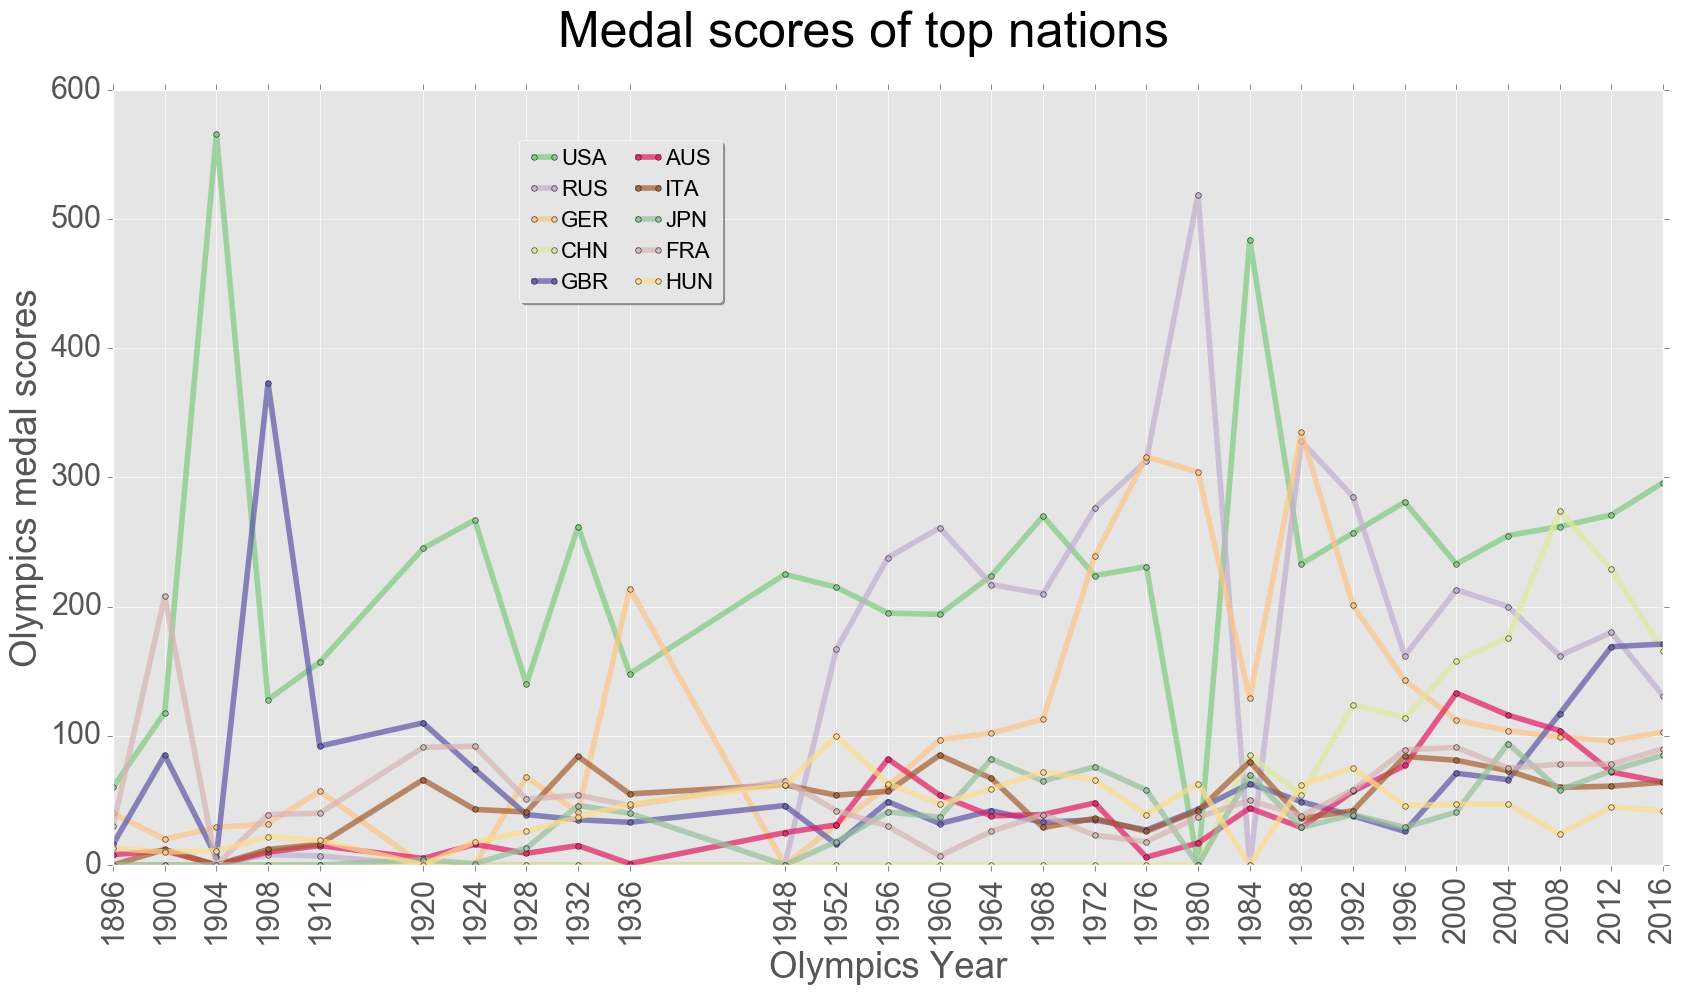

Figure 1: Medal scores of top 10 scoring nations calculated based on 4, 2, and 1 points
points allocated for each gold, silver, and bronze, respectivaly.



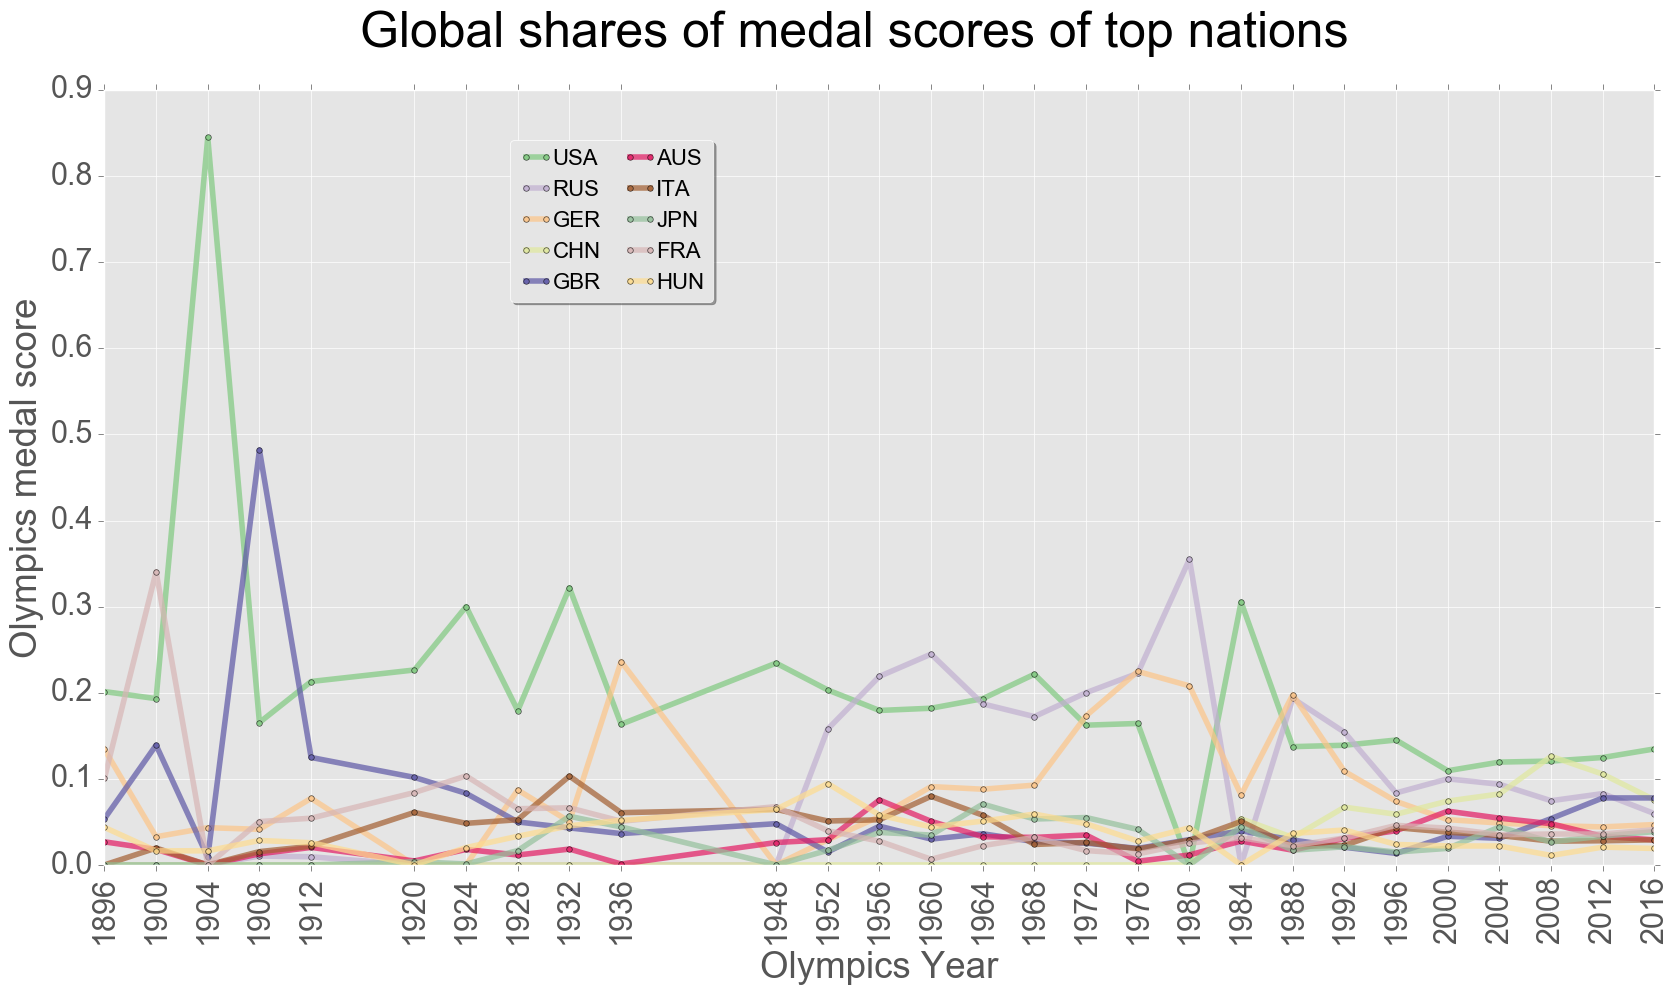

Figure 2: The global shares of the top scoring nations found by dividing the Figure 1a
data each year by each nation's Summer Olympics score accumulated through [1896,2016].



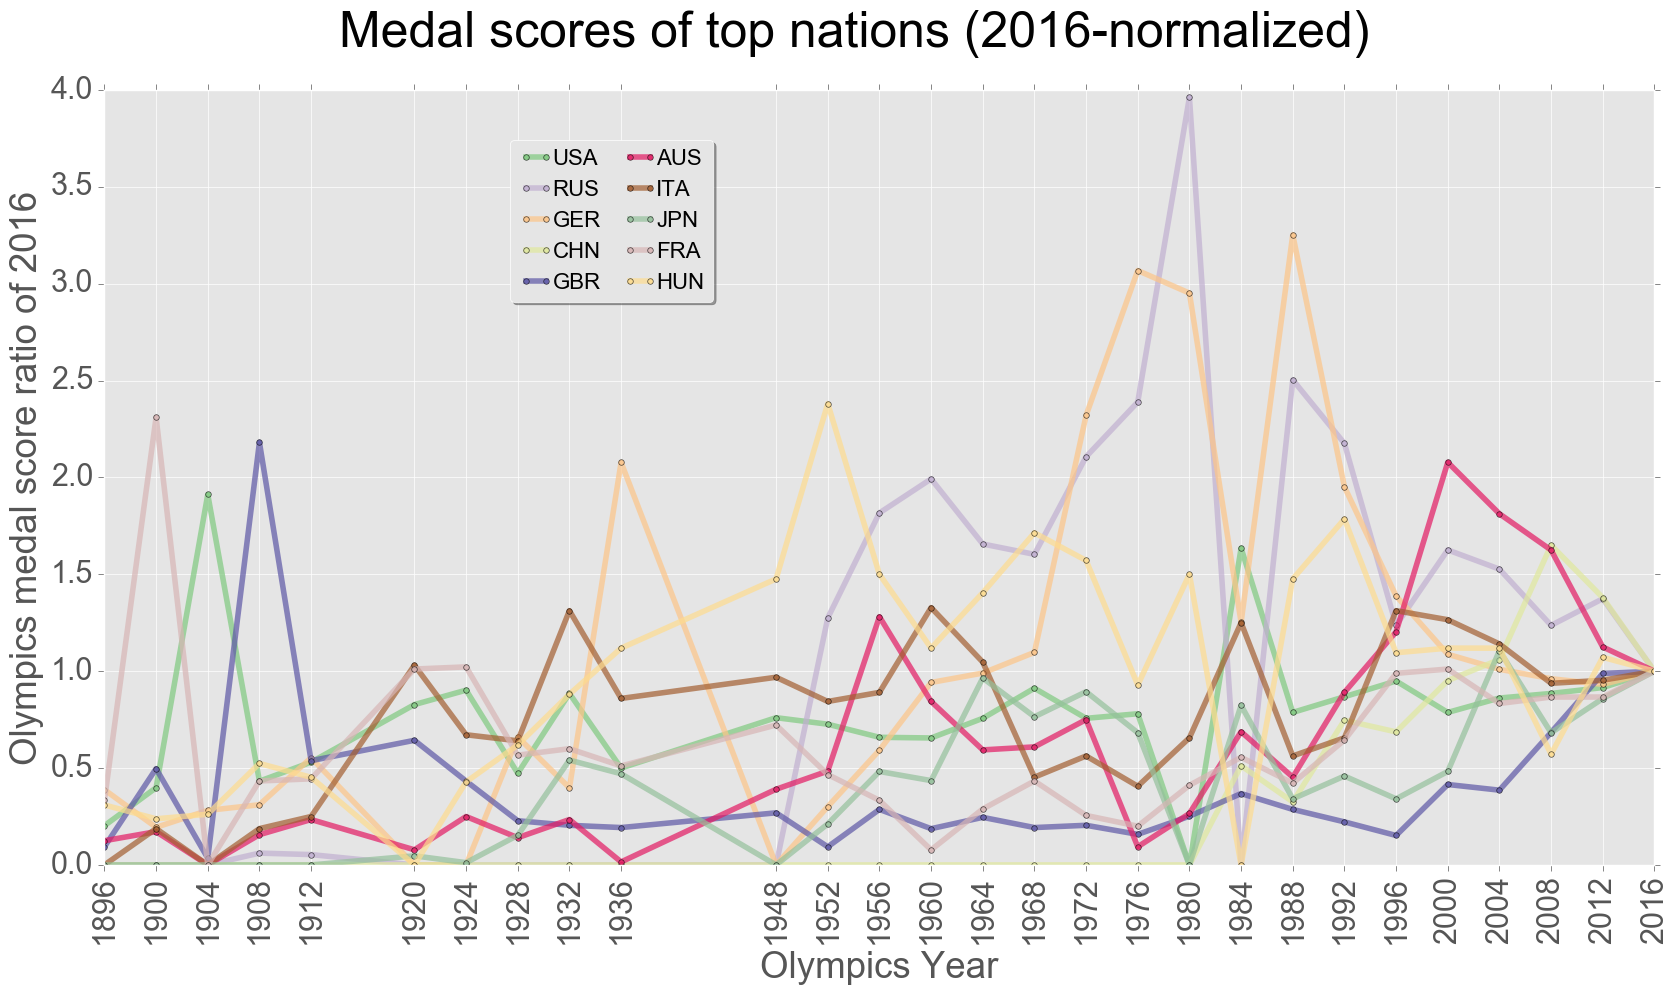

Figure 3: The plotted data of Figure 1a divided by each nation's 2016 score.



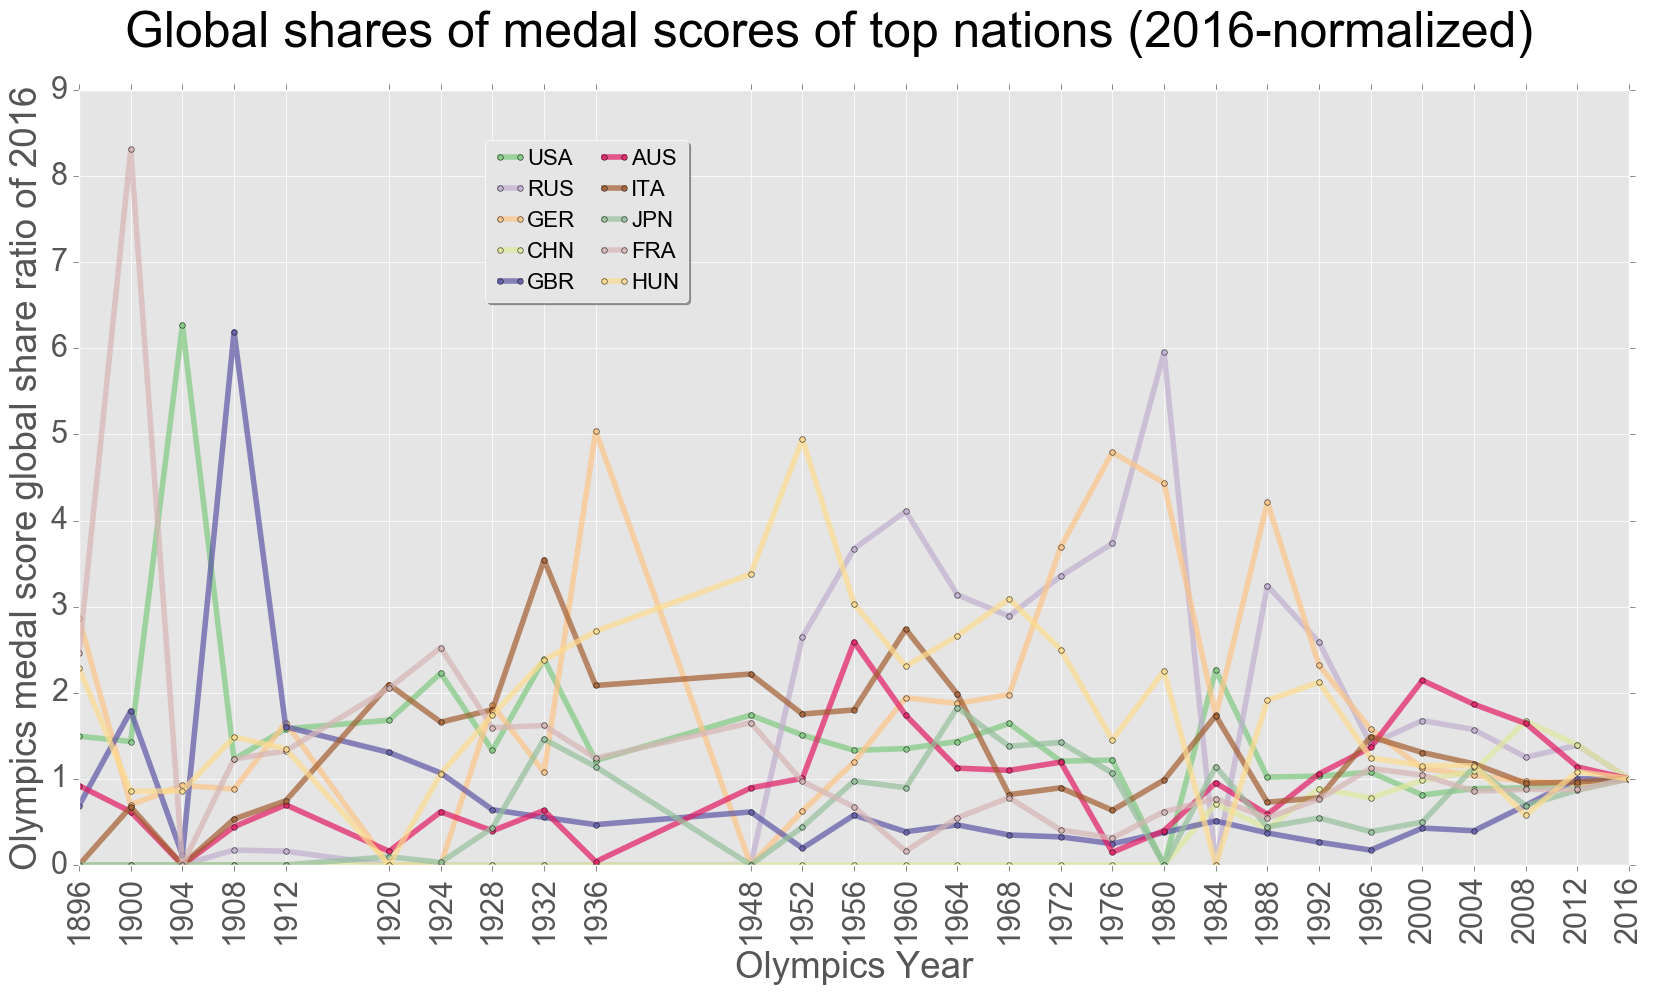

Figure 4: The plotted data of Figure 1b divided by each nation's 2016 score share.



In [4]:
""" Medal Trends Plot Segment: Plotting temporal medal trends of selected countries. """

# select_ctrs_df: Plotting temporal medal trends as countries' medal scores
prepare_plot("line", 1, select_ctrs_df, "Medal scores of top nations" , \
             "Olympics Year" , "Olympics medal scores", \
             olymp_yrs, select_ctrs_df.index , plt.cm.Accent, '-', 4.0, 'o', 4.0, 0.7, \
             False, (0,0), select_ctrs_df.index, False)
plt.show()
print ("Figure 1: Medal scores of top 10 scoring nations calculated based on 4, 2, and 1 points")
print ("points allocated for each gold, silver, and bronze, respectivaly.\n")

# select_shares_df: Plotting temporal medal trends as global shares of countries' medal scores
prepare_plot("line", 2, select_shares_df , "Global shares of medal scores of top nations" , \
             "Olympics Year" , "Olympics medal score", \
             olymp_yrs, select_shares_df.index , plt.cm.Accent, '-', 4.0, 'o', 4.0, 0.7, \
             False, (0,0), select_shares_df.index, False)
plt.show()
print ("Figure 2: The global shares of the top scoring nations found by dividing the Figure 1a")
print ("data each year by each nation's Summer Olympics score accumulated through [1896,2016].\n")

# select_2016normal_df: Plotting temporal medal trends as scores of countries 2016-normalized
prepare_plot("line", 3, select_2016normal_df , "Medal scores of top nations (2016-normalized)" , \
             "Olympics Year" , "Olympics medal score ratio of 2016", \
             olymp_yrs, select_2016normal_df.index , plt.cm.Accent, '-', 4.0, 'o', 4.0, 0.7, \
             False, (0,0), select_2016normal_df.index, False)
plt.show()
print ("Figure 3: The plotted data of Figure 1a divided by each nation's 2016 score.\n")

# select_shares_2016normal_df: Plotting temporal medal trends as score shares of countries 2016-normalized
prepare_plot("line", 4, select_shares_2016normal_df , "Global shares of medal scores of top nations (2016-normalized)" , \
             "Olympics Year" , "Olympics medal score global share ratio of 2016", \
             olymp_yrs, select_shares_2016normal_df.index , plt.cm.Accent, '-', 4.0, 'o', 4.0, 0.7, \
             False, (0,0), select_shares_2016normal_df.index, False)
plt.show()
print ("Figure 4: The plotted data of Figure 1b divided by each nation's 2016 score share.\n")


In [5]:
""" Epochs analysis Segment: Collecting information about nations' performances averaged through
 5 major epochs, followed by box-whisker plots of the trends through the epochs """

# Epoch bins: 1896-1912 (5), 1920-1936 (5), 1948-1964 (5), 1968-1984 (5), 1988-2016 (8)
epochs_list = ["1896-1912", "1920-1936", "1948-1964", "1968-1984", "1988-2016"]
bins = [olymp_yrs.index(i) for i in [1896, 1920, 1948, 1968, 1988]]
# Grouping into bins the data of scores
all_ctrs_df_transposed = all_ctrs_df.T
binned_scores_df_grpby = all_ctrs_df_transposed.groupby(np.digitize(all_ctrs_df_transposed.index, bins))
# Grouping into bins the data of score shares
all_shares_df_transposed = all_shares_df.T
binned_shares_df_grpby = all_shares_df_transposed.groupby(np.digitize(all_shares_df_transposed.index, bins))

# list of averaged score shares of countries during the 5 temporal epochs
indices1 = pd.Series()
epoch_shares_df = []
epoch_shares_top_nations_df = []
for i,h in binned_shares_df_grpby:
    thisSum = h.T.sum(axis=1)
    thisCnt = h.T.count(axis=1)
    thisAvg = thisSum/thisCnt
    top_nations_for_observation = thisAvg.nlargest(NUM_SELECTED_COUNTRIES+15)
    epoch_shares_df.append(thisAvg.to_frame())
    epoch_shares_top_nations_df.append(top_nations_for_observation.to_frame())
    indices1 = indices1.append(top_nations_for_observation.to_frame())

# list of averaged scores of countries during the 5 temporal epochs
indices2 = pd.Series()
epoch_scores_df = []
epoch_scores_top_nations_df = []
for i,h in binned_scores_df_grpby:
    thisSum = h.T.sum(axis=1)
    thisCnt = h.T.count(axis=1)
    thisAvg = thisSum/thisCnt
    top_nations_for_observation = thisAvg.nlargest(NUM_SELECTED_COUNTRIES+15)
    epoch_scores_df.append(thisAvg.to_frame())
    epoch_scores_top_nations_df.append(top_nations_for_observation.to_frame())
    indices2 = indices2.append(thisAvg.to_frame())

for i,_ in enumerate(epoch_scores_df):
    epoch_scores_df[i].columns = [i]
for i,_ in enumerate(epoch_shares_df):
    epoch_shares_df[i].columns = [i]
for i,_ in enumerate(epoch_scores_top_nations_df):
    epoch_scores_top_nations_df[i].columns = [i]
for i,_ in enumerate(epoch_shares_top_nations_df):
    epoch_shares_top_nations_df[i].columns = [i]

# Do any df-wide calculation here; I'm going to make ew dfs excluding outliers for a clean box-whisker plot, modified
# Determined manually as outliers were for each oclumn in num rows: { 0:6 , 1:7 , 2:7 , 3:10 , 4:10 }
epoch_scores_nontop, epoch_shares_nontop, top_scores, top_shares = [], [], [], []
nCols = len(epoch_scores_df)
phenolog_outlie_cutoff = 6
for i in range(nCols):
    if i==1: phenolog_outlie_cutoff = 7
    elif i==3: phenolog_outlie_cutoff = 10
    top_score_list = epoch_scores_top_nations_df[i].iloc[:phenolog_outlie_cutoff,0].index.values.tolist()
    top_share_list = epoch_shares_top_nations_df[i].iloc[:phenolog_outlie_cutoff,0].index.values.tolist()
    epoch_scores_nontop.append(epoch_scores_df[i].loc[~epoch_scores_df[i].index.isin(top_score_list)])
    epoch_shares_nontop.append(epoch_shares_df[i].loc[~epoch_shares_df[i].index.isin(top_share_list)])
    top_scores.append(epoch_scores_df[i].loc[epoch_scores_df[i].index.isin(top_score_list)])
    top_shares.append(epoch_shares_df[i].loc[epoch_shares_df[i].index.isin(top_share_list)])


def zero_to_nan(values):
    """ Replace every 0 with np.nan and return. """
    return [np.nan if x==0 else x for x in values]

epoch_all_scores_dfs_list, epoch_all_shares_dfs_list = [], []
for i,df in enumerate(epoch_scores_nontop):
    epoch_all_scores_dfs_list.append(pd.DataFrame(zero_to_nan(df.iloc[:,0])).dropna())
for i,df in enumerate(epoch_shares_nontop):
    epoch_all_shares_dfs_list.append(pd.DataFrame(zero_to_nan(df.iloc[:,0])).dropna())


In [6]:
""" Plot Preparation Function Segment: A helper function for drawing graphs to make code shorter """

def prepare_outlier_scatter_plot (fig_idx, df_list, ttl, x_lbl, y_lbl, x_tick_lbls, lgd_lbls, clr_map, \
                  ln_styl, ln_wd, mrk, mrk_sz, atten, x_x, idxs, ylog_bool):
    """ Plot DataFrame. rows form curves in cartesian. .columns forms x-axis values. """

    font = {'font.family':'Arial', 'font.weight':'normal', 'font.size':22}
    plt.rcParams.update(font)
    
    x_ticks_vals = []
    for i,itm in enumerate(df_list):
        x_ticks_vals += itm.columns.tolist()
        for _,idx in enumerate(itm.index):
            if ylog_bool:
                # Note: changed clrs_dict[idx]   to  clr_map
                plt.semilogy( itm.loc[idx,:], color=clr_map, linewidth=ln_wd, linestyle=ln_styl, marker=mrk, \
                          markerfacecolor=clr_map, markersize=mrk_sz, alpha=atten)
            else:
                plt.plot( itm.loc[idx,:], color=clr_map, linewidth=ln_wd, linestyle=ln_styl, marker=mrk, \
                          markerfacecolor=clr_map, markersize=mrk_sz, alpha=atten)

            for col,elem in enumerate(itm.loc[idx,:]):
                col = i   # col is either the idx of original list or df
                plt.annotate(idx, xy=(col,elem), xytext=(10,0), textcoords='offset points', \
                             fontsize=20, alpha=0.3, color=clr_map, fontweight='normal')
    
    plt.suptitle(ttl, fontsize=36)
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    plt.ylim(bottom=0)
    plt.xlim(df_list[0].columns[0]+x_x[0], df_list[-1].columns[-1]+x_x[1])
    plt.xticks(x_ticks_vals, x_tick_lbls, rotation='vertical')
    
    if len(lgd_lbls) > 0:
        legend = plt.legend( lgd_lbls, ncol=2, loc='best', fontsize=16, bbox_to_anchor=[0.4, 0.95], \
                   columnspacing=1.0, labelspacing=0.5, handletextpad=0.0, handlelength=1.5, \
                   fancybox=True, shadow=True )
    
    return

In [7]:
""" Segment for gathering data about Olympics hosts and numbers of nations participating. """

# Data from [4]
olympic_years = [ 1896, 1900, 1904, 1908, 1912, 1920, 1924, 1928, 1932, 1936, \
                 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, \
                 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016 ]
num_nations = [ 14, 24, 12, 22, 28, 29, 44, 46, 37, 49, \
               59, 69, 72, 84, 94, 112, 121, 92, 81, 140, \
               160, 169, 197, 199, 201, 204, 206, 206 ]
host_cities = [ "Athens", "Paris", "St. Louis", "London", "Stockholm", "Antwerp", "Paris", \
               "Amsterdam", "Los Angeles", "Berlin", "London", "Helsinki", "Melbourne", "Rome", \
               "Tokyo", "Mexico City", "Munich", "Montreal", "Moscow", "Los Angeles", "Seoul", \
               "Barcelona", "Atlanta", "Sydney", "Athens", "Beijing", "London", "Rio de Janeiro" ]
host_nocs = [ "GRE", "FRA", "USA", "GBR", "SWE", "BEL", "FRA", "NED", "USA", "GER", \
             "GBR", "FIN", "AUS", "ITA", "JPN", "MEX", "GER", "CAN", "RUS", "USA", \
             "KOR", "ESP", "USA", "AUS", "GRE", "CHN", "GBR", "BRA" ]

olymp_info = zip(num_nations, host_cities, host_nocs)
cols = ["Num Particip","Host City","Host Country"]
olymp_info_df = pd.DataFrame(list(olymp_info), index=olympic_years, columns=cols)
olymp_info_df.to_csv("olymp_host_info.csv")


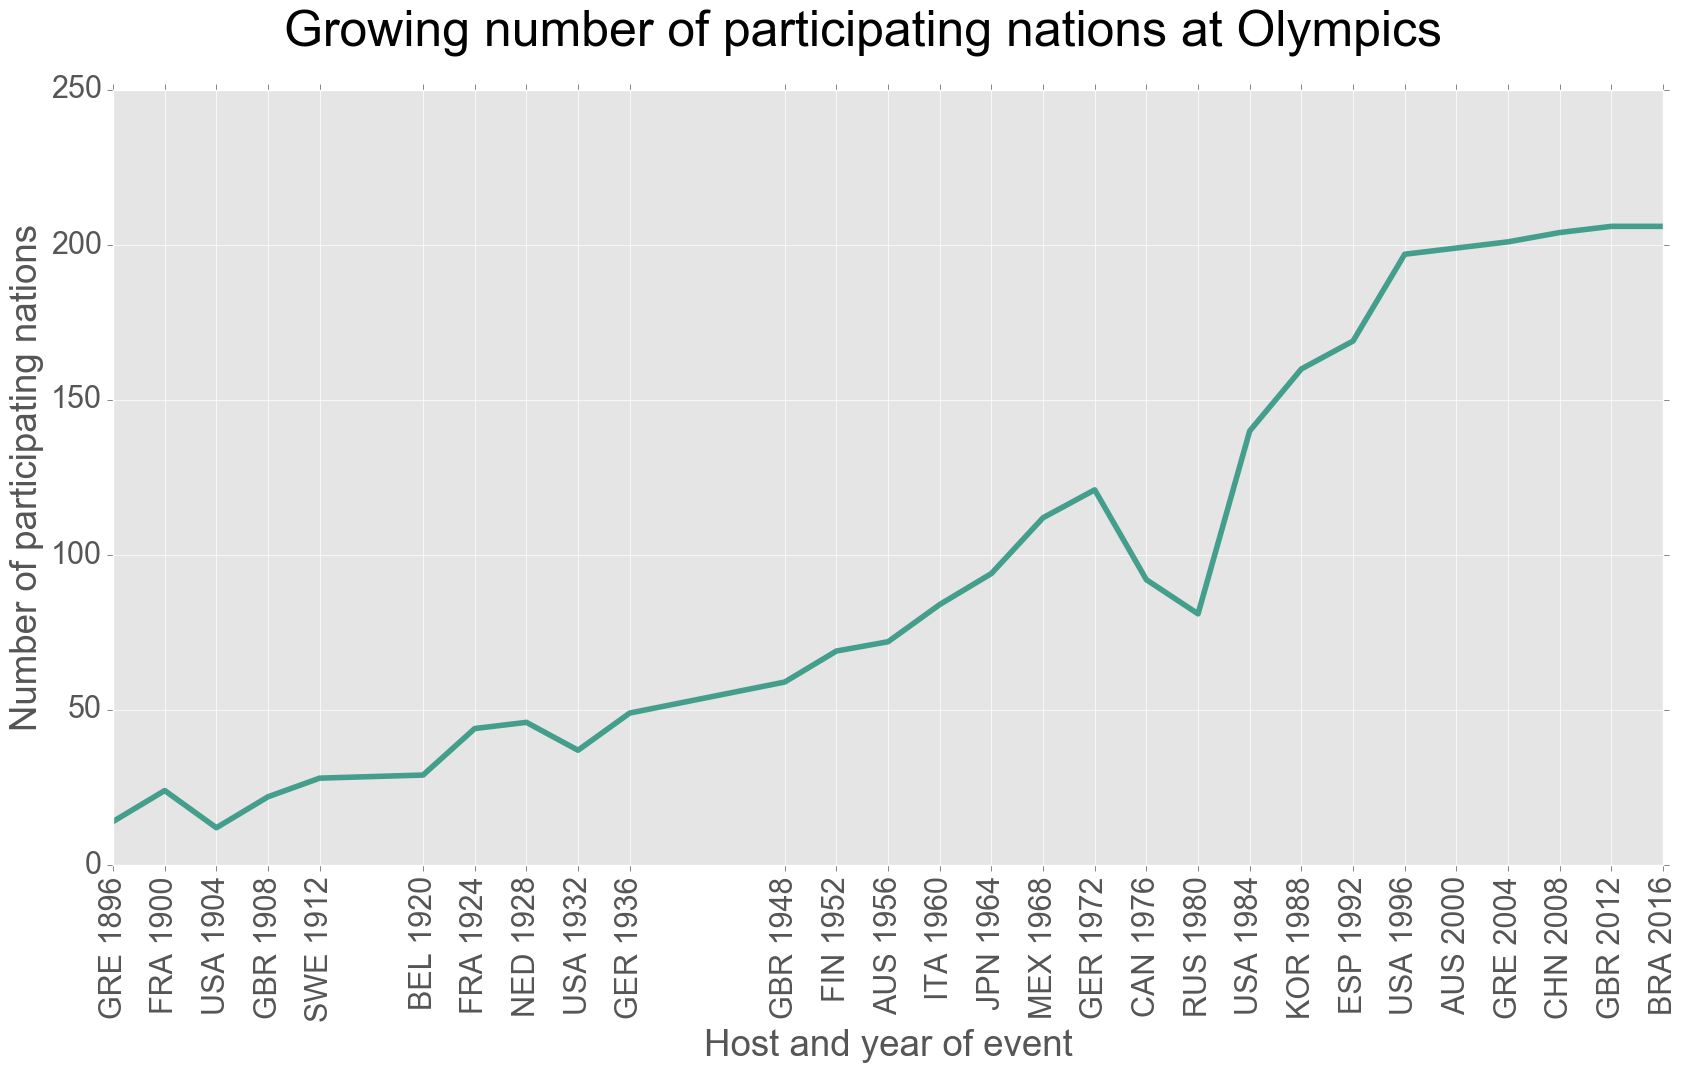

Figure 5: Growing number of summer games participating nations through Summer Olympics. [4]




In [8]:
""" Deriving medal winner among participants fractions through epochs """

olymp_info = pd.read_csv("olymp_host_info.csv", index_col=0)
pg_lim = len(olymp_info)//2

yr_host_zip_list = list(zip(olymp_info["Host Country"], olymp_yrs))
yr_host_list = list(map(lambda x: str(x[0])+" "+str(x[1]), yr_host_zip_list))
num_particip_df = pd.DataFrame(olymp_info["Num Particip"])
num_particip_df = num_particip_df.T.astype(float)

print ("\n")
# num_particip_df: Plotting the growth of the number of participating nations at the Olympics
prepare_plot("line", 1, num_particip_df, "Growing number of participating nations at Olympics" , \
             "Host and year of event" , "Number of participating nations", \
             yr_host_list, [] , plt.cm.summer, '-', 4.0, 'None', 4.0, 0.7, \
             False, (0,0), num_particip_df.index, False)
plt.show()
print ("Figure 5: Growing number of summer games participating nations through Summer Olympics. [4]")
print ("\n")

# Epoch bins: 1896-1912 (5), 1920-1936 (5), 1948-1964 (5), 1968-1984 (5), 1988-2016 (8)
epochs_list = ["1896-1912", "1920-1936", "1948-1964", "1968-1984", "1988-2016"]
bins = [1896, 1920, 1948, 1968, 1988]
# Grouping into bins the data of scores
olymp_info_grpby = olymp_info.groupby(np.digitize(olymp_info.index, bins))
olymp_epoch_info = olymp_info_grpby.sum()
#olymp_epoch_info["Non-0s"] = [len(i) for i in epoch_all_scores_dfs_list]
all_scores_all_yrs = all_ctrs_df.copy()
all_scores_all_yrs.columns = olymp_yrs
non0s = all_scores_all_yrs[all_scores_all_yrs != 0].count(axis=0)
non0s_grpby = non0s.groupby(np.digitize(non0s.index, bins))
olymp_epoch_info["Non-zeros"] = non0s_grpby.sum()
olymp_epoch_info["Fraction Zero"] = 1 - olymp_epoch_info["Non-zeros"]/olymp_epoch_info["Num Particip"]

olymp_epoch_info = olymp_epoch_info.T   # Transposing the table for presentation
olymp_epoch_info.columns = epochs_list


In [9]:
""" Segment ocntaining Function definitions for table styles """

def printFloat(x):
    if isinstance(x, float):
        if np.modf(x)[0] == 0:
            return str(int(x))
        else:
            return str("{:.2f}".format(x))   # equivalent old way: '%.2f' % (x)
    else: return str(x)
pd.options.display.float_format = printFloat


def format_table (data):
    """ relies on ipy_table modeule """
    if isinstance(data, pd.DataFrame):
        values_str_list = [list(map(printFloat, i)) for i in data.reset_index().values.tolist()]
        data_list = [['Period']+data.columns.tolist()] + values_str_list
    else: data_list = data.copy()
    tbl = ipy_table.make_table(data_list)
    #tbl.apply_theme('basic_both')
    tbl.set_global_style(align='center')
    return tbl



Table 4: Fractions of no-medal nations per Olympic event per epoch.


Period,1896-1912,1920-1936,1948-1964,1968-1984,1988-2016
Fraction Zero,0.22,0.32,0.46,0.61,0.61



Table 5: Outlier scoring nations, based on average medal scores, each period.


1896-1912,1920-1936,1948-1964,1968-1984,1988-2016
USA,USA,USA,RUS,USA
GBR,SWE,RUS,USA,RUS
FRA,FIN,HUN,GER,CHN
SWE,FRA,ITA,ROU,GER
GER,GER,GER,JPN,GBR
GRE,GBR,SWE,HUN,AUS
,ITA,AUS,ITA,FRA
,,,GBR,KOR
,,,BUL,ITA
,,,POL,JPN


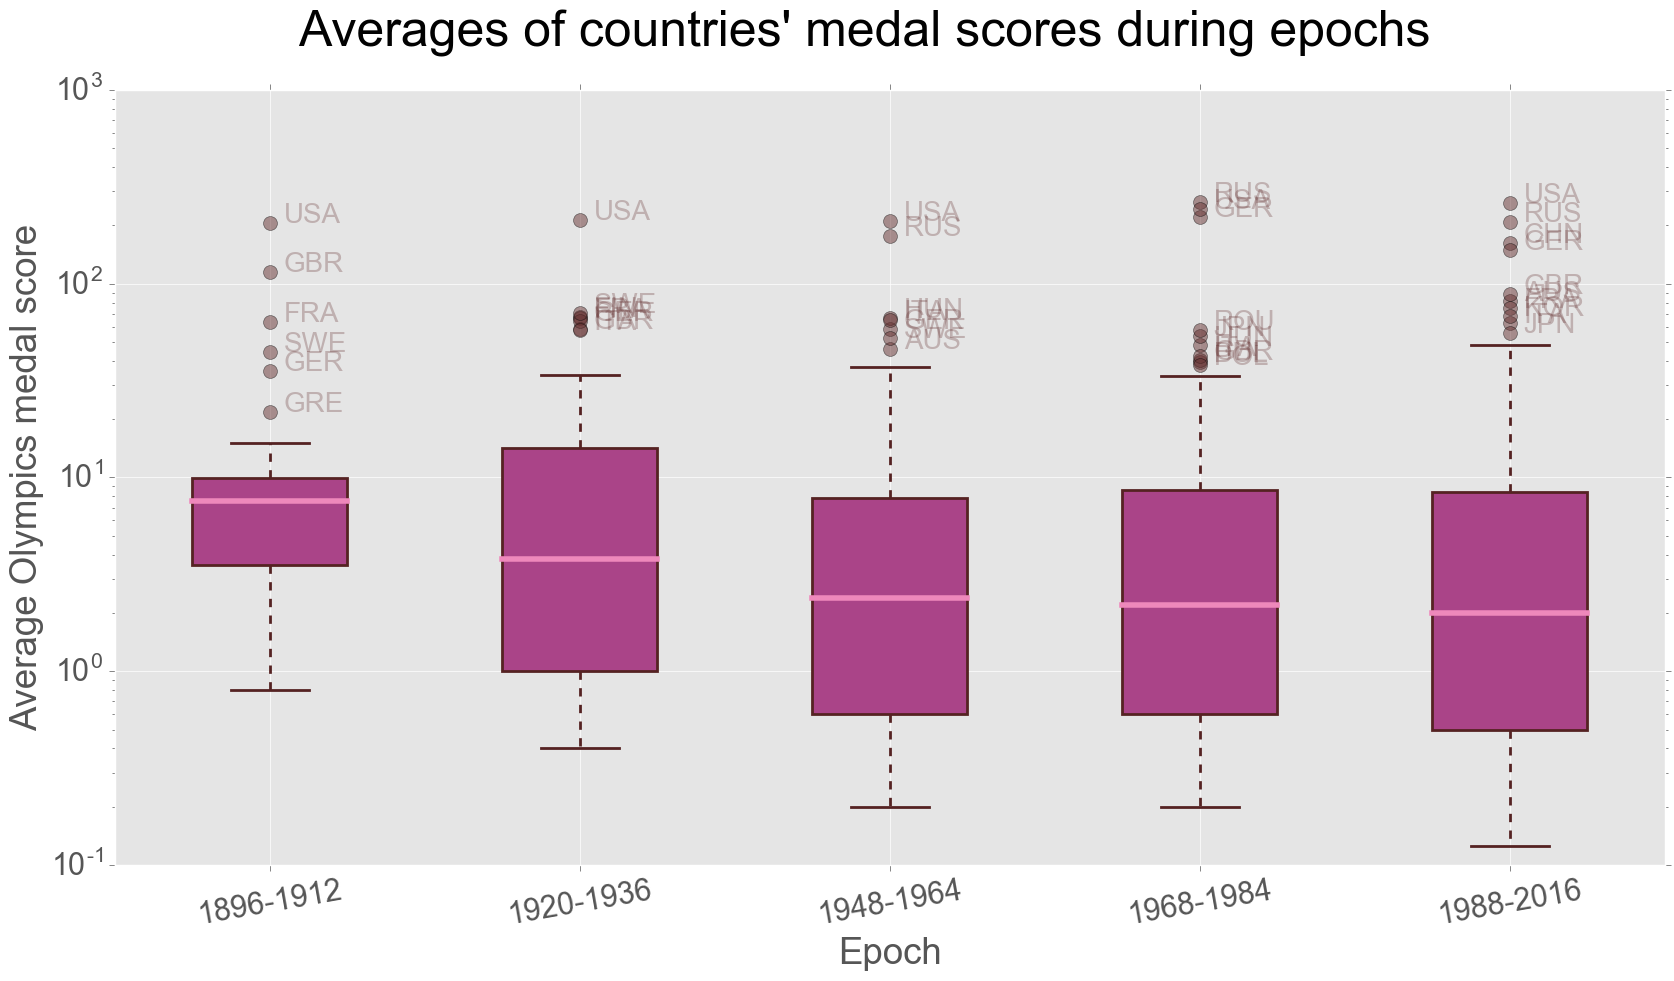

Figure 6: Epochs' box-plots showing nations' Summer Olympic medal score average distributions.



Table 6: Outlier scoring nations, based on average medal scores, each period.


1896-1912,1920-1936,1948-1964,1968-1984,1988-2016
USA,USA,USA,RUS,USA
GBR,SWE,RUS,USA,RUS
FRA,GER,HUN,GER,CHN
GRE,FIN,ITA,ROU,GER
GER,FRA,GER,JPN,GBR
SWE,ITA,SWE,HUN,AUS
,GBR,AUS,ITA,FRA
,,,BUL,KOR
,,,GBR,ITA
,,,POL,JPN


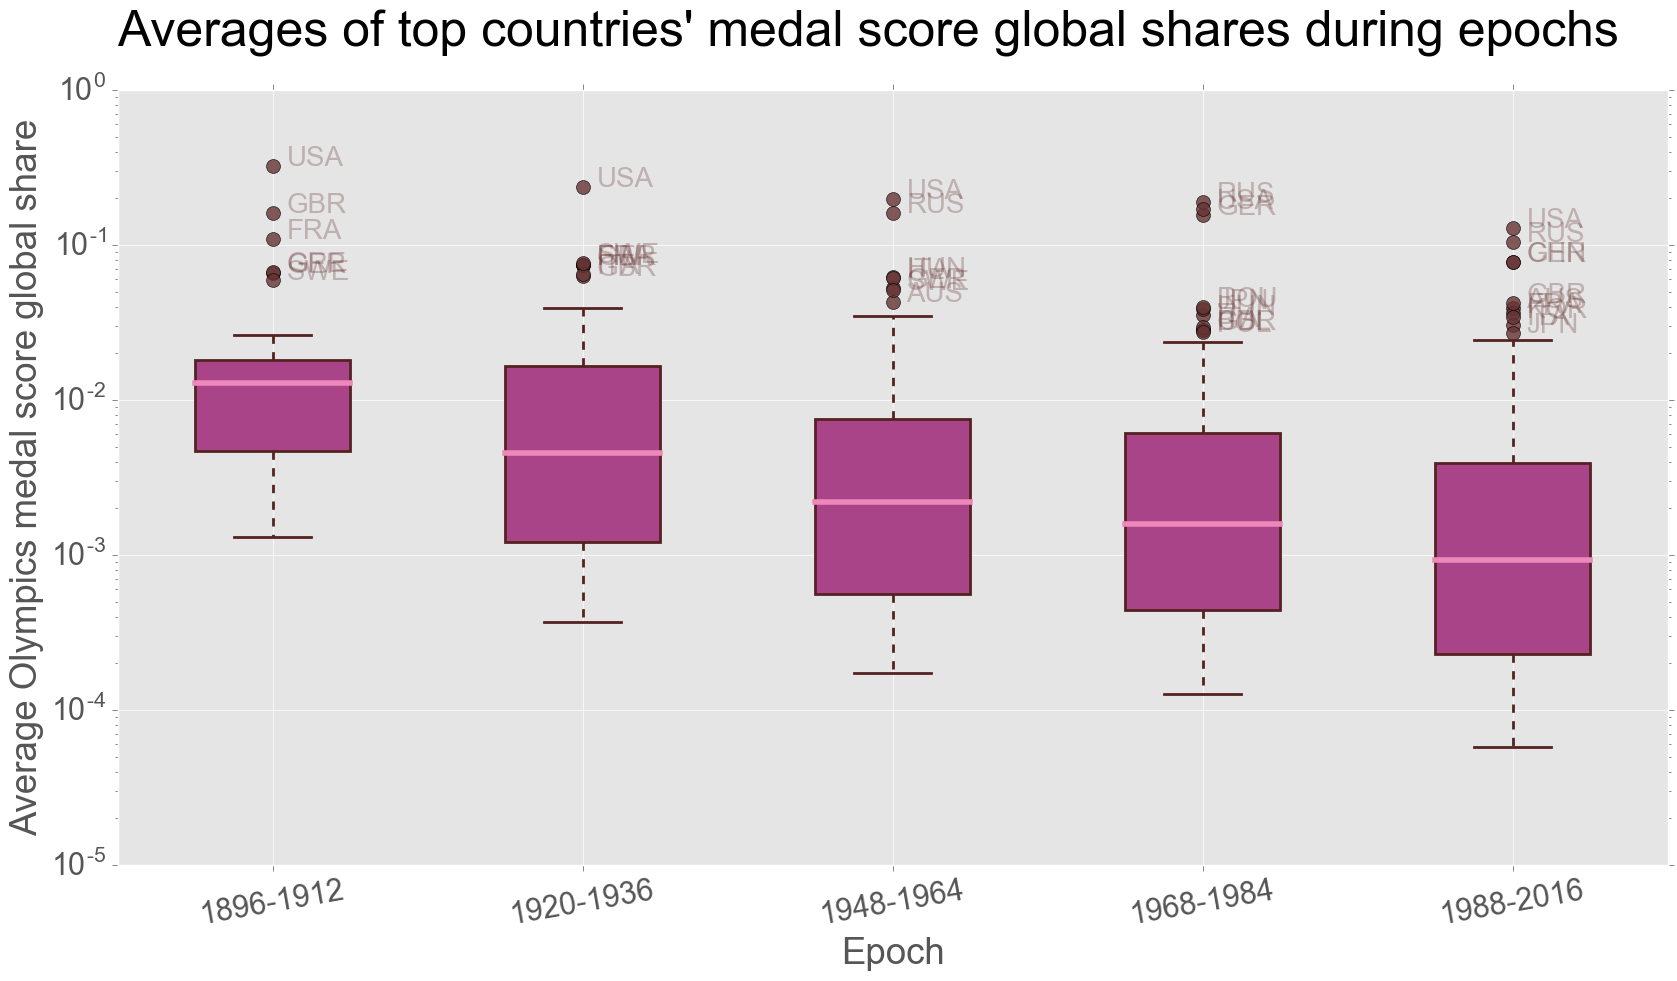

Figure 7: Epochs' box-plots of nations' global medal score share average distributions.



In [10]:
""" Segment of box-whisker plots showing Olympics performance during 5 epochs """

def stylize_boxplots (bps):
    EDG_CLR = "#552222"
    FAC_CLR = "#aa4488"#"#aa4488"#"#882222"
    MED_CLR = "#ee88bb"
    for bp in bps:
        for box in bp['boxes']:
            box.set(color=EDG_CLR, linewidth=2)
            box.set(facecolor = FAC_CLR)
        for whisker in bp['whiskers']:
            whisker.set(color=EDG_CLR, linewidth=2)
        for cap in bp['caps']:
            cap.set(color=EDG_CLR, linewidth=2)
        for median in bp['medians']:
            median.set(color=MED_CLR, linewidth=4)
        for flier in bp['fliers']:
            flier.set(marker='o', color=EDG_CLR, alpha=0.5)
    return

print()
# Produce the table showing fractions of nations producing no medal among countries each period
fr0_df = pd.DataFrame(olymp_epoch_info.T["Fraction Zero"]).T
print ("Table 4: Fractions of no-medal nations per Olympic event per epoch.")
display (format_table(fr0_df))
print ()

CLR = "#663333"   # chnaged from colormap plt.cm.Accent to single color, used inbox-plots

# Note: Outliers are selected manually and excluded from the box-plot data, so the box-plots
    # reflect distributions of ~140 points, 5-10 reasonable outliers of them excluded
scores_outliers = []
for i,df in enumerate(top_scores):
    scores_outliers.append( df.sort_values([i], ascending=False).index )
scores_outliers_df = pd.DataFrame(scores_outliers).T.fillna("")
scores_outliers_df.columns = epochs_list
score_outlier_list = [list(map(printFloat, i)) for i in scores_outliers_df.values.tolist()]
score_outlier_list = [scores_outliers_df.columns.tolist()] + score_outlier_list
score_outlier_table = format_table(score_outlier_list)
score_outlier_table.set_global_style(no_border='all', )
score_outlier_table.set_row_style(0, bold=True)
print ("Table 5: Outlier scoring nations, based on average medal scores, each period.")
display (score_outlier_table)
print ()

bps = []
# Scatter plot for complement of previous plot: Averages of top countries' medal scores during epochs
plt.figure(5, figsize=(20,10))
prepare_outlier_scatter_plot(5, top_scores , "Averages of countries' medal scores during epochs", \
         "Epoch" , "Average Olympics medal score", epochs_list, [], \
         CLR, 'None', 4.0, 'o', 10.0, 0.5, (-0.5,0.5), indices2.index.unique(), True)
# Box-plot for Averages of non-top countries' medal scores during epochs
bps.append(plt.boxplot(epoch_all_scores_dfs_list, notch=False, positions=range(5), \
                       whis='range', patch_artist=True))
plt.ylim(bottom=0.1)
plt.xticks(range(5), epochs_list, rotation=10)
stylize_boxplots (bps)
plt.show()
print ("Figure 6: Epochs' box-plots showing nations' Summer Olympic medal score average distributions.")
print ("\n\n")


# TODO: If same behaviour below as above, def function, just input scores and shares dataframes
# Note: Outliers are selected manually and excluded from the box-plot data, so the box-plots
    # reflect distributions of ~140 points, 5-10 reasonable outliers of them excluded
shares_outliers = []
for i,df in enumerate(top_shares):
    shares_outliers.append( df.sort_values([i], ascending=False).index )
shares_outliers_df = pd.DataFrame(shares_outliers).T.fillna("")
shares_outliers_df.columns = epochs_list
share_outlier_list = [list(map(printFloat, i)) for i in shares_outliers_df.values.tolist()]
share_outlier_list = [shares_outliers_df.columns.tolist()] + share_outlier_list
share_outlier_table = format_table(share_outlier_list)
share_outlier_table.set_global_style(no_border='all')
share_outlier_table.set_row_style(0, bold=True)
print ("Table 6: Outlier scoring nations, based on average medal scores, each period.")
display (share_outlier_table)
print ()

# Scatter plot for complement of previous plot: Averages of top countries' medal score global shares during epochs
plt.figure(7, figsize=(20,10))
prepare_outlier_scatter_plot(7, top_shares , "Averages of top countries' medal score global shares during epochs", \
         "Epoch" , "Average Olympics medal score global share", epochs_list, [], \
         CLR, 'None', 4.0, 'o', 10.0, 0.8, (-0.5,0.5), indices1.index.unique(), True)
# Box-plot for Averages of non-top countries' medal score global shares during epochs
bps.append(plt.boxplot(epoch_all_shares_dfs_list, notch=False, positions=range(5), \
                       whis='range', patch_artist=True))
plt.ylim(bottom=0.00001)
plt.xticks(range(5), epochs_list, rotation=10)
stylize_boxplots (bps)
plt.show()
print ("Figure 7: Epochs' box-plots of nations' global medal score share average distributions.")
print ()
